<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/page_satus_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [2]:
import sys, pickle, os, json, keras, time, re
from sklearn.model_selection import KFold
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import models
from keras import layers
import numpy as np
from google.colab import files
from keras.metrics import categorical_accuracy
from scipy.stats import zscore
import random
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
mecab = MeCab.Tagger("-Owakati")

Using TensorFlow backend.


In [0]:
def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/status_filter/"
!ls "/content/gdrive/My Drive/data/status_filter/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
page_st.csv  sample.csv  text_token.pickle  used_page_st.csv  weights.best.h5


In [18]:
page_file_name = 'page_st.csv'
target_columns = ['label','text']
dtype ={'label':str,'text':str} 
raw_df = pd.read_csv(base_dir + page_file_name,sep=',',error_bad_lines=False, dtype=dtype,engine='python')
raw_df = raw_df[~raw_df.duplicated()]
print('raw_df',raw_df.shape)
print(raw_df.columns)
print(raw_df['label'].value_counts())
raw_df.to_csv(base_dir+page_file_name,index=False)

raw_df (700, 3)
Index(['label', 'url', 'text'], dtype='object')
stock     441
no        193
top        20
list       13
nan        13
login      12
block       5
except      3
Name: label, dtype: int64


In [0]:
def change_label(label):
  if label != 'stock' :label = 'no'
  return label

raw_df['label'] = raw_df['label'].apply(lambda x : change_label(x))

In [20]:
raw_df = raw_df.dropna()
raw_df = raw_df.sample(frac=1)
print(raw_df["label"].value_counts())
print('raw_df',raw_df.shape)
print(raw_df.columns)


stock    441
no       259
Name: label, dtype: int64
raw_df (700, 3)
Index(['label', 'url', 'text'], dtype='object')


In [31]:
text = 'sorry we can t this product page 　　re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 ました 売り 切れ ページ 見つかり ません この 製品 もう 入手 できません'
def prepro(text:str)->list:
  line = ""
  text = mecab.parse(str(text)).replace("↵"," ")
  text = re.sub('{.*}','',text)
  words = text.lower().split(' ')
  for word in words:
    regex = "^(此|宝|贝|已|下架|품절|또는|판매가|중지된|상품입니다|access|trova|negozio|unfortunate|denied|esaurito|online|only|sorry|we|can|this|product|page|re|sold|404|whoops|ARTICOLO NON DISPONIBILE|our|bad|it|gone|out|of|low|stock|select|no|one|size|please|choose|cat|add|選択|カート|追加|切れ|在庫|なし|し|完売|ました|売り|切れ|ページ|見つかり|ませ|ん|この|製品|もう|入手|でき|ない|ci|scusiamo|per|inconveniente|back|to|our|favs|product|page|item|requested|is|was|not|found|no|longer|server|error|available|購入|いただけ|ません|ARTICLE|EN|LIGNE|so|articolo|non|disponibile|很抱歉|您|查看|的|页面|找不到|了)";
    regex = regex.lower()
    match = re.search(regex, word)
    if match:
      line += word+" "
#   print('line',len(line.split()))
  return line
prepro(text)


'sorry we can this product page re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 売り 切れ ページ 見つかり ませ ん この 製品 もう 入手 でき ませ ん '

In [32]:
raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
regex = "^(sorry.? (we can.t|this (product|page)))|^(sorry we.re sold out)|^(404|whoops, our bad...|it.s gone|out of stock|sold out|在庫切れ|在庫なし|完売しました|売り切れ|ページが見つかりません.*|この製品はもう入手できない.|ci scusiamo per l'inconveniente.|sorry!|back to our favs)$|(((product|page|item|requested) (is |was )?)(not found|no longer|sold out|out of stock|not available))|(re (sorry|sold out)|(ご購入いただけません)|(404 error))|^(sold out\\s*){3,}|ARTICLE.*EN LIGNE|^so sorry.*|404 page not|Don.t Cry|.*is out of stock.|articolo non disponibile";
p = re.compile(regex)
raw_df['flag'] = raw_df['text'].apply(lambda x : 0 if p.match(x) == None else 1)
raw_df['edit_text'] = raw_df['edit_text'].fillna("")

token = keras.preprocessing.text.Tokenizer(num_words=200)
token.fit_on_texts(raw_df['edit_text'].values)
save_text_tokenizer(token,base_dir + 'text_token')
X = token.texts_to_matrix(raw_df['edit_text'].values)
flag = np.array(raw_df['flag'])
flag = flag.reshape(len(flag),1)
print('flag',flag.shape,'X',X.shape)
X = np.concatenate((flag,X),axis=1)

# X = flag
# text_len = len(X[0])
# print(f'text_len:{text_len} samples:{len(X)}')
print('word_count',len(token.word_counts))
print(token.word_counts)
print(token.word_index)
X = np.array(X)
print('X',X.shape)

flag (700, 1) X (700, 200)
word_count 897
OrderedDict([('items', 176), ('accessories', 227), ('page', 158), ('were', 27), ('to', 2954), ('not', 626), ('this', 690), ('is', 456), ('outdated', 5), ('address', 73), ('we', 428), ('re', 84), ('sorry', 50), ('can', 144), ('offer', 55), ('our', 874), ('offers', 114), ('returns', 705), ('notice', 78), ('size', 1082), ('catwalk', 7), ('ourselves', 6), ('so', 58), ('wear', 75), ('it', 585), ('of', 1187), ('reserved', 212), ('en', 134), ('backpack', 63), ('now', 205), ('add', 577), ('back', 166), ('redefines', 1), ('city', 40), ('accessorizing', 2), ('adds', 8), ('its', 87), ('enduring', 1), ('tone', 56), ('relations', 9), ('repair', 1), ('カート', 49), ('item', 197), ('し', 381), ('了承', 8), ('在庫', 54), ('製品', 71), ('circus', 3), ('accessoriesactivewearface', 22), ('soft', 67), ('please', 223), ('select', 262), ('product', 400), ('out', 361), ('adding', 11), ('tomorrow', 12), ('wears', 34), ('wash', 43), ('regrets', 5), ('office', 28), ('available', 

In [0]:
index2word =  {i+1:key for i, key in enumerate(token.word_index)}
# index2word

In [0]:
# label_token = keras.preprocessing.text.Tokenizer()
# label_token.fit_on_texts(raw_df['label'].values)
# y = label_token.texts_to_matrix(raw_df['label'].values)
# label_len = len(label_token.word_counts) + 1

y = to_categorical(raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0))
# print('word_index',label_token.word_index)
# print('label_len',label_len)
# print('y shape',y.shape)

In [35]:

def get_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Embedding(1000, 64, input_length= len(X[0])))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(256,activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(512,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(256,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(2,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer =keras.optimizers.RMSprop(),metrics=['categorical_accuracy'])
  return model

get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 201, 64)           64000     
_________________________________________________________________
flatten_11 (Flatten)         (None, 12864)             0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 12864)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               3293440   
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 514       
Total params: 3,357,954
Trainable params: 3,357,954
Non-trainable params: 0
_________________________________________________________________


In [36]:

EPOCHS = 25
BATCH_SIZE = 32

# stop when score is not improve
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=20)

# save best score
filepath = base_dir+"weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')

# reduce 
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
callbacks_list = [checkpoint,early_stopping,reduce]

scores = []
historys = []
kf = KFold(n_splits=4, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
  model = get_model()
  history = model.fit(X[train_index], y[train_index], validation_split=0.2,verbose=0,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
  historys.append(history)
  score = model.evaluate(X[test_index],y[test_index])
  print(score)
  scores.append(score)

load_model = keras.models.load_model(filepath)
score = load_model.evaluate(X[test_index],y[test_index])
print('Test best loss:', score[0])
print('Test best accuracy:', score[1])

175/175 [==============================] - 0s 98us/step
[0.7935780504771641, 0.7714285721097673]
175/175 [==============================] - 0s 86us/step
[0.5788259390422276, 0.8342857156481062]
175/175 [==============================] - 0s 95us/step
[0.7714408605439322, 0.777142858164651]
175/175 [==============================] - 0s 102us/step
[0.6602719650949751, 0.8514285717691694]
175/175 [==============================] - 0s 2ms/step
Test best loss: 0.3938468495437077
Test best accuracy: 0.8742857149669102


In [37]:
print("KFlod")
print("Sample",len(X))
print("Score",pd.DataFrame(scores).mean()[1]*100)


KFlod
Sample 700
Score 80.85714294229234


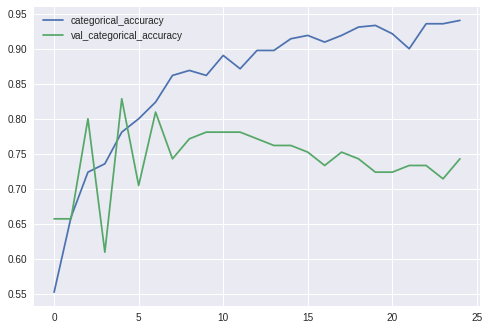

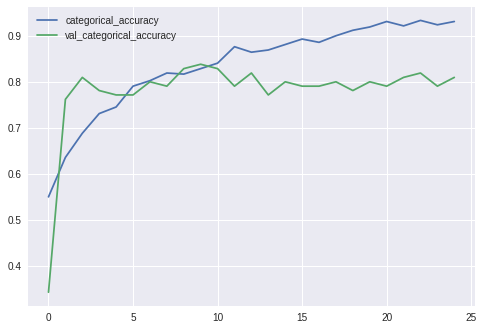

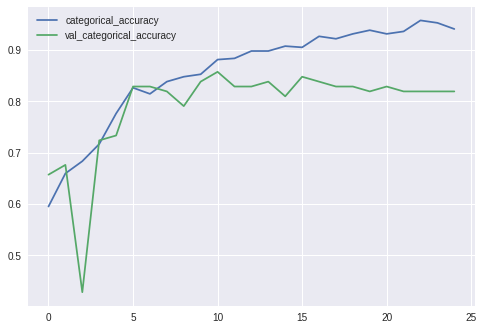

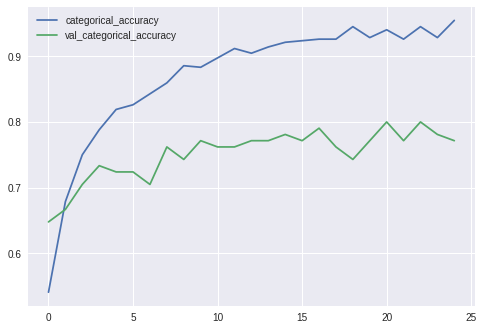

In [38]:
for i in range(len(historys)):
  df = pd.DataFrame(historys[i].history)
#   df.filter(regex=('loss*')).plot()
  df.filter(regex=('accuracy$')).plot()
  
plt.show()
  

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


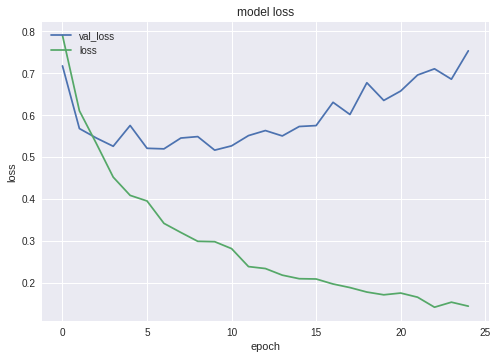

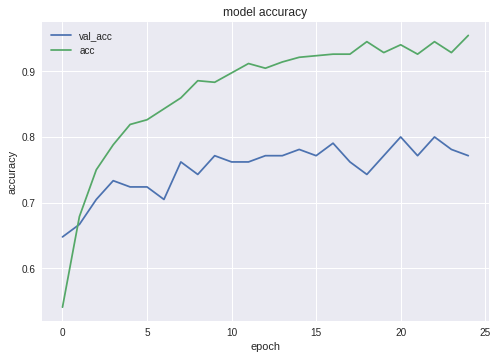

In [39]:

import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()

In [40]:
print('word_index',label_token.word_index)

results = load_model.predict(X_test)
for i in range(len(results)):
  pred = np.argmax(results[i])
  ans = np.argmax(y_test[i])
  if pred == ans:continue
  print(pred ,'!=' ,ans)
  words = ""
  for k, x in enumerate(X_test[i]):
    if x == 0:continue
    words += index2word.get(k) +" "
  print(words)

NameError: ignored